Задание
Цель:
закрепить знания о математическом смысле метрик TPR, FPR. Изучить построение ROC-кривой, графика Precision-Recall.

Описание задания:
Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.

Этапы работы:
Преобразуйте данные:
a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;

b. закодируйте категориальные переменные числовыми значениями по необходимости.

Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.

Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.

Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.

Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.

Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.

*Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.

9/ Сформулируйте выводы по проделанной работе:

a. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?

b. *может ли ROC-кривая проходить ниже диагонали?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from scikitplot.metrics import plot_roc_curve

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


import datetime
from datetime import datetime
from dateutil.parser import parse

In [2]:
# датасет содержит данные спортсменов Олимпиады в Рио в 2016г.

data = pd.read_csv('athletes.csv')
data

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11533,265605954,Zurian Hechavarria,CUB,female,8/10/95,1.64,58.0,athletics,0,0,0
11534,214461847,Zuzana Hejnova,CZE,female,12/19/86,1.73,63.0,athletics,0,0,0
11535,88361042,di Xiao,CHN,male,5/14/91,1.85,100.0,wrestling,0,0,0
11536,900065925,le Quoc Toan Tran,VIE,male,4/5/89,1.60,56.0,weightlifting,0,0,0


In [3]:

# идея в том, чтобы установить факт награждения/ненаграждения любой медалью.
# поэтому на основании трех столбцов создам столбец с бинарными значениями

data['reward'] = np.where((data[['gold', 'silver', 'bronze']].sum(axis=1)), 1, 0)
data

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,reward
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11533,265605954,Zurian Hechavarria,CUB,female,8/10/95,1.64,58.0,athletics,0,0,0,0
11534,214461847,Zuzana Hejnova,CZE,female,12/19/86,1.73,63.0,athletics,0,0,0,0
11535,88361042,di Xiao,CHN,male,5/14/91,1.85,100.0,wrestling,0,0,0,0
11536,900065925,le Quoc Toan Tran,VIE,male,4/5/89,1.60,56.0,weightlifting,0,0,0,0


In [4]:
# 'gold', 'silver', 'bronze' теперь не нужны, удалим
data.drop(columns=['gold', 'silver', 'bronze'], inplace=True) 

In [5]:
# отфильтрую  возможные дубли. Так как возможны полные тёзки, добавлю условиe совпадение очевидные - id
data = data.drop_duplicates(subset=['name', 'id'])
data

,id,name,nationality,sex,dob,height,weight,sport,reward
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0
...,...,...,...,...,...,...,...,...,...
11533,265605954,Zurian Hechavarria,CUB,female,8/10/95,1.64,58.0,athletics,0
11534,214461847,Zuzana Hejnova,CZE,female,12/19/86,1.73,63.0,athletics,0
11535,88361042,di Xiao,CHN,male,5/14/91,1.85,100.0,wrestling,0
11536,900065925,le Quoc Toan Tran,VIE,male,4/5/89,1.60,56.0,weightlifting,0


In [6]:
# посмотрим количество пропусков
data.isna().mean()*100

id             0.000000
name           0.000000
nationality    0.000000
sex            0.000000
dob            0.008667
height         2.860114
weight         5.711562
sport          0.000000
reward         0.000000
dtype: float64

In [7]:
data.loc[data['dob'].isna()]

,id,name,nationality,sex,dob,height,weight,sport,reward
8546,663676373,Pavel Sozykin,RUS,male,NaN,NaN,NaN,sailing,0


In [8]:
# Павел Валерьевич Созыкин (род. 25 декабря 1987, Челябинск) — российский яхтсмен,
# бронзовый призёр чемпионатов мира и Европы 2015 года в соревнованиях в классе 470,
# чемпион России, Мастер спорта международного класса.

In [9]:
data.loc[8546, 'dob'] = 1987

In [10]:
# имена и id не несут полезной информации 
del data['name']
del data['id']

In [11]:
# перевод даты рождения в год рождения, 
# чтобы получить возраст спортсменов на год проведения Олимпиады

data['dob'] = pd.to_datetime(data['dob']).dt.strftime('%Y')
data

,nationality,sex,dob,height,weight,sport,reward
0,ESP,male,2069,1.72,64.0,athletics,0
1,KOR,female,1986,1.68,56.0,fencing,0
2,CAN,male,1992,1.98,79.0,athletics,1
3,MDA,male,1991,1.83,80.0,taekwondo,0
4,NZL,male,1990,1.81,71.0,cycling,0
...,...,...,...,...,...,...,...
11533,CUB,female,1995,1.64,58.0,athletics,0
11534,CZE,female,1986,1.73,63.0,athletics,0
11535,CHN,male,1991,1.85,100.0,wrestling,0
11536,VIE,male,1989,1.60,56.0,weightlifting,0


In [12]:
data.dtypes

nationality     object
sex             object
dob             object
height         float64
weight         float64
sport           object
reward           int32
dtype: object

In [13]:
# чтобы проводить арифметические действия нужно перевести в тип int
data['dob'] = data['dob'].astype(int)

In [14]:
def p_date(date): 
    '''
    получаем возраст спортсмена разницей года проведения Олимпиады
    и года рождения 
    избегаем появления возрастов на сто лет старше реального    
    '''
    date_olymp = 2016
    dt = date
    if dt > 2002:
       dt = dt - 100   
    return date_olymp - dt

data['age'] = data['dob'].apply(p_date) 
data

,nationality,sex,dob,height,weight,sport,reward,age
0,ESP,male,2069,1.72,64.0,athletics,0,47
1,KOR,female,1986,1.68,56.0,fencing,0,30
2,CAN,male,1992,1.98,79.0,athletics,1,24
3,MDA,male,1991,1.83,80.0,taekwondo,0,25
4,NZL,male,1990,1.81,71.0,cycling,0,26
...,...,...,...,...,...,...,...,...
11533,CUB,female,1995,1.64,58.0,athletics,0,21
11534,CZE,female,1986,1.73,63.0,athletics,0,30
11535,CHN,male,1991,1.85,100.0,wrestling,0,25
11536,VIE,male,1989,1.60,56.0,weightlifting,0,27


In [15]:
del data['dob']

In [16]:
data[ pd.isnull(data['weight'])]

,nationality,sex,height,weight,sport,reward,age
12,IOA,male,NaN,NaN,aquatics,0,24
28,ALG,male,1.86,NaN,boxing,0,30
30,ALG,male,1.78,NaN,boxing,0,30
37,EGY,male,1.85,NaN,boxing,0,29
47,ITA,male,NaN,NaN,athletics,0,30
...,...,...,...,...,...,...,...
11465,KAZ,female,1.54,NaN,boxing,0,27
11468,KAZ,male,1.82,NaN,boxing,0,23
11513,ALG,male,1.78,NaN,boxing,0,30
11514,MAR,female,1.65,NaN,boxing,0,33


In [17]:
data[ pd.isnull(data['height'])]

,nationality,sex,height,weight,sport,reward,age
12,IOA,male,NaN,NaN,aquatics,0,24
47,ITA,male,NaN,NaN,athletics,0,30
50,GHA,male,NaN,NaN,boxing,0,23
52,IOA,male,NaN,NaN,fencing,0,26
56,BAN,male,NaN,NaN,shooting,0,27
...,...,...,...,...,...,...,...
11031,FIJ,male,NaN,NaN,boxing,0,23
11208,ERI,male,NaN,NaN,athletics,0,18
11220,ESA,female,NaN,NaN,athletics,0,22
11238,SUR,male,NaN,NaN,judo,0,31


In [18]:
df = data.copy()

In [19]:
height_bins = df.groupby('sport')

In [20]:
# объект SeriesGroupBy находится в переменной df.height,
# применим к нему lambda-функцию через метод .apply()
df['height'] = height_bins['height'].apply(lambda x: x.fillna(x.median()))

In [21]:
df

,nationality,sex,height,weight,sport,reward,age
0,ESP,male,1.72,64.0,athletics,0,47
1,KOR,female,1.68,56.0,fencing,0,30
2,CAN,male,1.98,79.0,athletics,1,24
3,MDA,male,1.83,80.0,taekwondo,0,25
4,NZL,male,1.81,71.0,cycling,0,26
...,...,...,...,...,...,...,...
11533,CUB,female,1.64,58.0,athletics,0,21
11534,CZE,female,1.73,63.0,athletics,0,30
11535,CHN,male,1.85,100.0,wrestling,0,25
11536,VIE,male,1.60,56.0,weightlifting,0,27


In [22]:
df['height'].isna().mean()*100

0.0

In [23]:
weight_bins = df.groupby('sport')

In [24]:
weight_bins['weight'].unique()

sport
aquatics             [100.0, nan, 68.0, 72.0, 90.0, 61.0, 115.0, 88...
archery              [76.0, 65.0, 84.0, 64.0, 77.0, 74.0, 51.0, 70....
athletics            [64.0, 79.0, 62.0, 54.0, 63.0, 66.0, 49.0, 57....
badminton            [81.0, 85.0, 55.0, 77.0, 59.0, 60.0, 80.0, 70....
basketball           [90.0, 65.0, 95.0, 85.0, 102.0, 68.0, 76.0, 93...
boxing                                                           [nan]
canoe                [85.0, 82.0, 84.0, 60.0, 99.0, 50.0, 88.0, 77....
cycling              [71.0, 66.0, 58.0, 68.0, 69.0, 55.0, 62.0, 63....
equestrian           [67.0, 55.0, 62.0, 50.0, 65.0, 70.0, 80.0, 86....
fencing              [56.0, nan, 58.0, 63.0, 87.0, 82.0, 62.0, 73.0...
football             [64.0, 68.0, 75.0, 70.0, 79.0, 65.0, 62.0, 71....
golf                 [79.0, 57.0, 58.0, 48.0, 69.0, 65.0, 80.0, 75....
gymnastics           [35.0, 58.0, 46.0, 54.0, 48.0, 45.0, 70.0, 77....
handball             [77.0, 93.0, 95.0, 105.0, 100.0, 79.0, 69.0, 8...


In [25]:
df['weight'] = weight_bins['weight'].apply(lambda x: x.fillna(x.median()))

In [26]:
# нет данных по весу у всех боксеров. имеем 286 таких значений. Удалю эти строки
# а надо было данные указывать!
df.dropna(axis = 'index', subset = ['weight'], inplace = True)

In [27]:
df

,nationality,sex,height,weight,sport,reward,age
0,ESP,male,1.72,64.0,athletics,0,47
1,KOR,female,1.68,56.0,fencing,0,30
2,CAN,male,1.98,79.0,athletics,1,24
3,MDA,male,1.83,80.0,taekwondo,0,25
4,NZL,male,1.81,71.0,cycling,0,26
...,...,...,...,...,...,...,...
11533,CUB,female,1.64,58.0,athletics,0,21
11534,CZE,female,1.73,63.0,athletics,0,30
11535,CHN,male,1.85,100.0,wrestling,0,25
11536,VIE,male,1.60,56.0,weightlifting,0,27


In [28]:
# возможно, географическое происхождение спортсмена важно для предсказания его результативности
# но, оценить это сложно, к тому же спорсмен мог и менять гражданства
# поэтому, из модели географию удалю
del df['nationality']

In [29]:
df = pd.get_dummies (df, columns=['sex', 'sport'], drop_first= True )
df.head(3)

,height,weight,reward,age,sex_male,sport_archery,sport_athletics,sport_badminton,sport_basketball,sport_canoe,...,sport_rugby sevens,sport_sailing,sport_shooting,sport_table tennis,sport_taekwondo,sport_tennis,sport_triathlon,sport_volleyball,sport_weightlifting,sport_wrestling
0,1.72,64.0,0,47,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.68,56.0,0,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.98,79.0,1,24,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


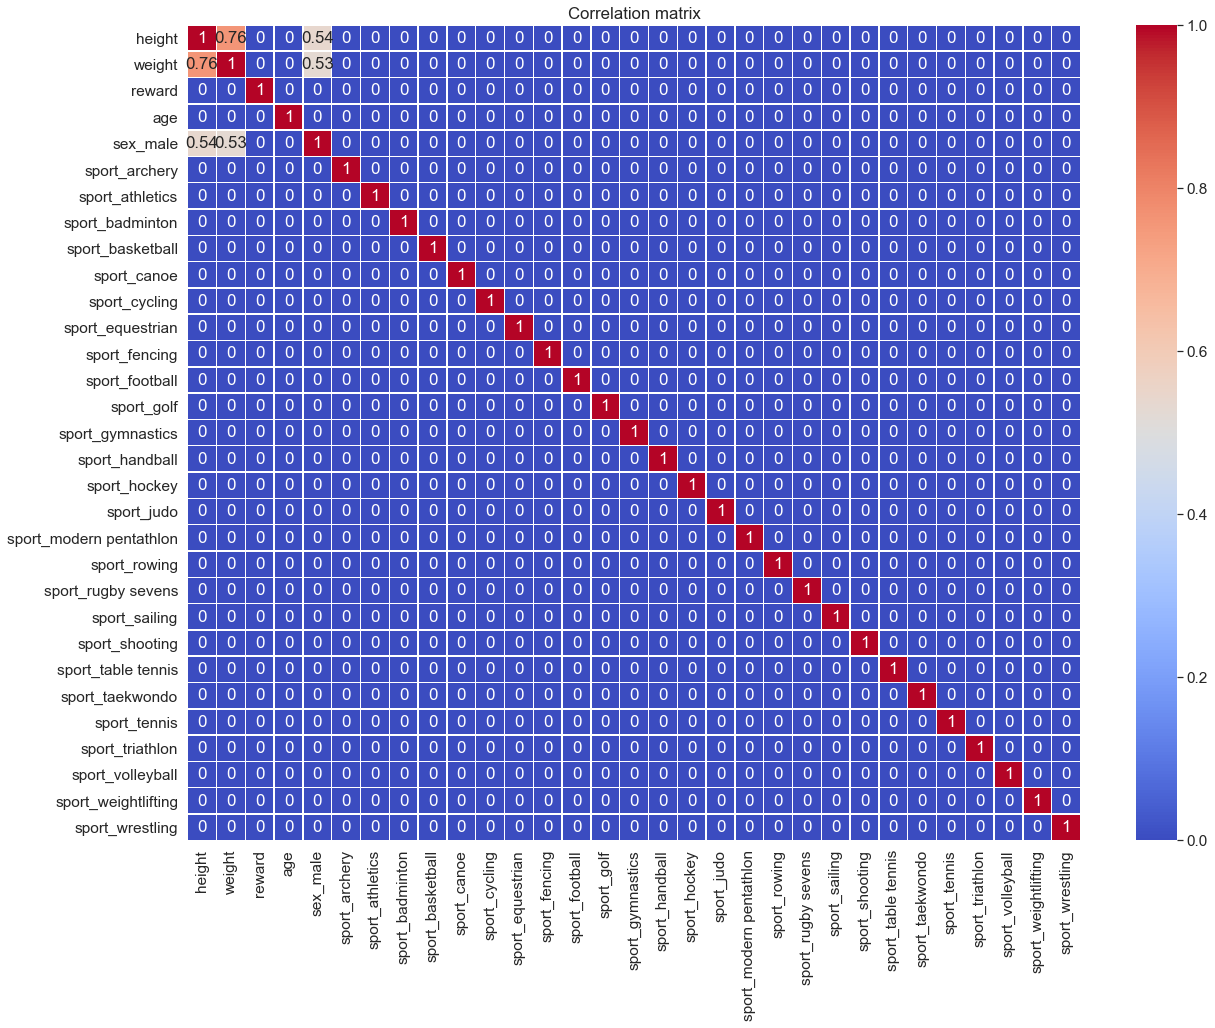

In [30]:
plt.figure(figsize=(20, 15))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

####  Судя по матрице корреляций, виды спорта вообще не вносят вклад. Удалю их из модели

In [31]:
y = df['sex_male']

In [32]:

X = df[['reward', 'height', 'weight', 'age']]
X.head(3)

,reward,height,weight,age
0,0,1.72,64.0,47
1,0,1.68,56.0,30
2,1,1.98,79.0,24


In [33]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X.mean(axis=0), X.std(axis=0)
# приведем признаки к одному масштабу

(array([1.07351818e-16, 4.11094313e-16, 4.36353564e-16, 2.32385111e-16]),
 array([1., 1., 1., 1.]))

In [34]:
model = LogisticRegression()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1984)

In [36]:
model.fit(X_train, y_train)

LogisticRegression()

In [37]:
predictions = model.predict_proba(X_test)

In [38]:
predictions[:4]

array([[0.254806  , 0.745194  ],
       [0.71156253, 0.28843747],
       [0.79997088, 0.20002912],
       [0.86310459, 0.13689541]])

In [39]:
model.score(X_test, y_test)

0.7658818302976454

In [40]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 0, 1], dtype=uint8)

In [41]:
tp = 0 # True positive
fp = 0 # False positive
fn = 0 # False negative
tn = 0 # True negative

predictions = model.predict_proba( X_test )
for predicted_prob, actual in zip( predictions[:, 1], y_test ):    
    if predicted_prob >= 0.5:
        predicted = 1
    else:
        predicted = 0
    
    if predicted == 1:
        if actual == 1:
            tp += 1
        else:
            fp += 1
    
    else:
        if actual == 1:
            fn += 1
        else:
            tn += 1 

In [42]:
tp, fp, fn, tn 

(942, 275, 252, 782)

In [43]:
pd.DataFrame(confusion_matrix(y_pred, y_test),
             columns = ['Forecast 0', 'Forecast 1'],
             index = ['Actual 0', 'Actual 1'])

,Forecast 0,Forecast 1
Actual 0,782,252
Actual 1,275,942


In [44]:
print(f'accuracy = {metrics. accuracy_score (y_test, y_pred)}')

print(f'precision = {metrics. precision_score (y_test, y_pred)}')

print(f'recall = {metrics. recall_score (y_test, y_pred)}')

accuracy = 0.7658818302976454
precision = 0.7740345110928513
recall = 0.7889447236180904


In [45]:
# вручную посчитаем метрики 
print(f'accuracy = {(tp + tn) / (tp + fp + fn + tn)}')

print(f'precision = {tp / (tp + fp)}')

print(f'recall = {tp / (tp + fn)}')

print(f'FPR = {fp / (fp + tn)}')

print(f'TPR = {tp / (tp + fn)}')

accuracy = 0.7658818302976454
precision = 0.7740345110928513
recall = 0.7889447236180904
FPR = 0.26017029328287605
TPR = 0.7889447236180904


In [46]:
# получаем значения false и true positive rate для различных значений порога
fpr, tpr, thres = roc_curve( y_test, predictions[:, 1] )

In [47]:
for line in zip( fpr, tpr, thres ):
    print( line )

(0.0, 0.0, 1.9997729444055652)
(0.0, 0.0008375209380234506, 0.9997729444055652)
(0.0, 0.03433835845896147, 0.9906050556988191)
(0.000946073793755913, 0.03433835845896147, 0.9904023969114698)
(0.000946073793755913, 0.06197654941373534, 0.9842810490959804)
(0.001892147587511826, 0.06197654941373534, 0.9840398759191903)
(0.001892147587511826, 0.09715242881072027, 0.9721147260036163)
(0.002838221381267739, 0.09715242881072027, 0.9720860590818189)
(0.002838221381267739, 0.1273031825795645, 0.9623239830116914)
(0.003784295175023652, 0.1273031825795645, 0.9615245897309885)
(0.003784295175023652, 0.1507537688442211, 0.951985232104347)
(0.004730368968779565, 0.1507537688442211, 0.9519627607411766)
(0.004730368968779565, 0.16164154103852596, 0.9476007890005385)
(0.005676442762535478, 0.16164154103852596, 0.9472078209265602)
(0.005676442762535478, 0.17169179229480738, 0.9443410999463041)
(0.006622516556291391, 0.17169179229480738, 0.9442864736806292)
(0.006622516556291391, 0.17336683417085427, 0.

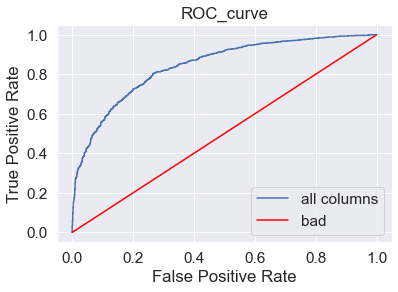

In [48]:
plt.plot( fpr, tpr, label='all columns')

plt.plot(np.linspace(0, 1), np.linspace(0, 1), color ='red', label='bad')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc=0)



In [49]:
roc_auc_score(y_test, predictions[:, 1])

0.8427924865576701

In [50]:
auc(fpr, tpr)

0.8427924865576701

#### Вывод:

Судя по полученным метрикам, я бы назвал качество модели "на три четверти", - значения метрик примерно 

равны 0,75. А FPR почти равно 0,25, то есть доля неверных ответов одна четверть.

График ROC-curve вполне понятно отображает ситуацию.

Считаю модель отработала адекватно, но неидеально.
